In [1]:
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt

from coffea.nanoaod import NanoEvents

In [2]:
from pyinstrument import Profiler
profiler = Profiler()
profiler.start()

from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods import FatJet, LorentzVector

arraycache = {}
events = NanoEvents.from_file(
    # 'data/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8.root',
    # 'root://cmsxrootd-site.fnal.gov//store/mc/RunIIFall17NanoAODv6/QCD_Pt_50to80_TuneCP5_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/280000/FDFE267A-9BCF-6347-A4DE-CC108EEAC18E.root',
    # 'data/EGamma-Run2018D.root',
    # 'data/TTToHadronic_TuneCP5_13TeV-powheg-pythia8_10X.root',
    'data/RunIIAutumn18NanoAODv5_BulkGravTohhTohWWhbb.root',
    #entrystop=20000,
    cache=arraycache,
    methods={
        'FatJetPFCands': LorentzVector,
    },
)
print(arraycache)

profiler.stop()

{}


In [3]:
#%%timeit

profiler = Profiler()
profiler.start()

gen = events.GenPart

where = (
    (abs(gen.pdgId) == 5)
    & (np.abs(gen.distinctParent.pdgId) == 6).fillna(False)
    & gen.hasFlags(['isHardProcess'])
)
genb = gen[where]

gentop = genb.distinctParent
hasWmu = (
    (abs(gentop.children.pdgId) == 24)
    & (abs(gentop.children.children.pdgId) == 13).any()
).any()

chosenb = genb[hasWmu]

profiler.stop()

In [4]:
with open('profile.html', 'w') as fout:
    fout.write(profiler.output_html())

In [5]:
(abs(gentop.children.pdgId) == 24).count()

<JaggedArray [[] [] [] ... [] [] []] at 0x0001276db050>

In [6]:
gentop.pdgId

<JaggedArray [[] [] [] ... [] [] []] at 0x000128961050>

In [7]:
gentop.children.pdgId

<JaggedArray [[] [] [] ... [] [] []] at 0x000128a53210>

In [8]:
x = np.unique(chosenb.counts, return_counts=True)
x[0], x[1] / 20000

(array([0]), array([0.05]))

In [9]:
genele = events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isHardProcess', 'isLastCopy'])
]
genele_fromW = genele[
    (genele.distinctParent.pdgId == 24)
]
genW = genele_fromW.distinctParent

In [10]:
leadingmuon = events.Muon.pad(1, clip=True).flatten()
leadingjet = events.FatJet.pad(1, clip=True).flatten()
met = events.MET

In [11]:
from uproot_methods import TLorentzVectorArray

In [12]:
joffshell = leadingjet.msoftdrop < 125/2  # halfway point between offshell and onshell W
massassumption = 80.*joffshell + (125 - 80.)*~joffshell
x = massassumption**2/(2*leadingmuon.pt*met.rho) + np.cos(leadingmuon.phi - met.phi)
met_eta = (
    (x < 1)*np.arcsinh(x*np.sinh(leadingmuon.eta))
    + (x > 1)*(
        leadingmuon.eta
        - np.sign(leadingmuon.eta)*np.arccosh(leadingmuon.eta)
    )
)
met_p4 = TLorentzVectorArray.from_ptetaphim(met.rho, met_eta.fillna(0.), met.phi, np.zeros(met.size))

/Users/ncsmith/src/awkward-array/awkward/array/masked.py:242: RuntimeWarning: invalid value encountered in arccosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
leadingmuon

<MaskedArray [<Muon 0> None None ... <Muon 1573> <Muon 1574> <Muon 1575>] at 0x000128a308d0>

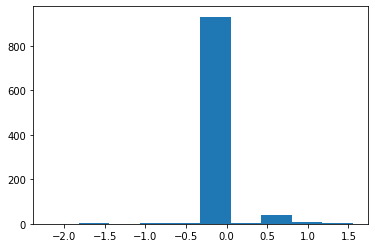

In [14]:
plt.hist(met_p4.eta);

In [15]:
bosons = events.GenPart[
    (np.abs(events.GenPart.pdgId) >= 21)
    & (np.abs(events.GenPart.pdgId) <= 37)
    & events.GenPart.hasFlags(['isHardProcess', 'isLastCopy'])
]
candidatejet = events.FatJet[:,:1]
ak8_boson_pair = candidatejet.cross(bosons, nested=True)
ak8_boson_pair['dR2'] = ak8_boson_pair.i0.delta_r2(ak8_boson_pair.i1)
ak8_boson_pair['dPt2'] = ((ak8_boson_pair.i0.pt - ak8_boson_pair.i1.pt)/(ak8_boson_pair.i0.pt + ak8_boson_pair.i1.pt))**2

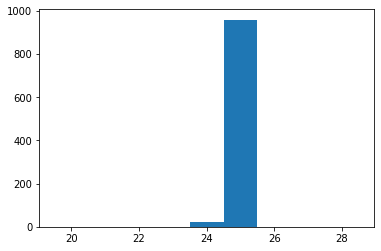

In [16]:
matchedBoson = ak8_boson_pair.i1[(ak8_boson_pair.dR2 + ak8_boson_pair.dPt2).argmin()].flatten(axis=1)
plt.hist(matchedBoson.pdgId.flatten(), bins=np.arange(20, 30)-.5);

In [17]:
fatjets = events.FatJet
from boostedhiggs import corrections

fatjets['msdcorr'] = corrections.corrected_msoftdrop(fatjets)
fatjets['rho'] = 2*np.log(fatjets.msdcorr / fatjets.pt)
fatjets['n2ddt'] = fatjets.n2b1 - corrections.n2ddt_shift(fatjets, year='2018')

/Users/ncsmith/src/awkward-array/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


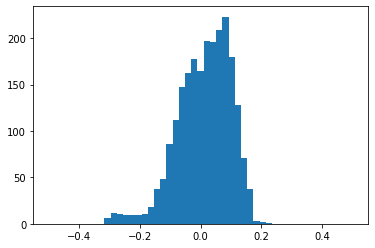

In [18]:
plt.hist(fatjets.n2ddt.flatten(), bins=np.linspace(-0.5, 0.5, 50));

In [19]:
leadingjet = fatjets[:, 0:1]

good = ((leadingjet.pt > 450)
        & (np.abs(leadingjet.eta) < 2.4)
        & (leadingjet.jetId & 2).astype(bool)  # tight
        & (leadingjet.n2ddt < 0.)
        & (leadingjet.msdcorr > 40)
       )

good_event = good.all()

In [20]:
jets = events.Jet
ak4_ak8_pair = jets.cross(leadingjet, nested=True)
dphi = ak4_ak8_pair.i0.delta_phi(ak4_ak8_pair.i1)
opp = (np.abs(dphi) > np.pi / 2).all()
# only consider first 4 jets to be consistent with old framework
ak4_opposite = jets[opp & (jets.pt > 30.) & (jets.array.localindex < 4)]

btagLooseWPs = {
    '2016': 0.6321,
    '2017': 0.4941,
    '2018': 0.4184,
}
good_event &= ak4_opposite.btagDeepB.max() < btagLooseWPs['2018']

In [21]:
nelectrons = ((events.Electron.cutBased >= events.Electron.LOOSE) & (events.Electron.pt > 20)).counts
nmuons = (events.Muon.looseId & (events.Muon.pt > 20)).counts
ntaus = (events.Tau.idDecayMode & (events.Tau.pt > 20)).counts
good_event &= (events.MET.pt < 140.) & (nmuons == 0) & (nelectrons == 0) & (ntaus == 0)

In [22]:
print("Passed %d of %d events" % (good_event.sum(), good_event.size))

Passed 16 of 1000 events


In [23]:
list(arraycache.keys())

['0001869b9814221e11eaa85b82bde183beef;Events;0;1000;nGenPart',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;GenPart_pdgId',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;GenPart_genPartIdxMother',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;GenPart_statusFlags',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;nMuon',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;nFatJet',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;FatJet_msoftdrop',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;Muon_pt',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;MET_phi',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;MET_pt',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;Muon_phi',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;Muon_eta',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;FatJet_eta',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;GenPart_eta',
 '0001869b9814221e11eaa85b82bde183beef;Events;0;1000;FatJet_phi',
 

In [24]:
events.Muon.matched_gen.pdgId

<JaggedArray [[-13] [] [] ... [-13] [None] [-13]] at 0x000126451a50>

In [25]:
lscut = (events.FatJet.muonIdx3SJ >= 0)
events = events[lscut.any()]
lscut = lscut[lscut.any()]

In [26]:
cut = lscut & (events.FatJet.pt - events.FatJet.LSpt < 5.)

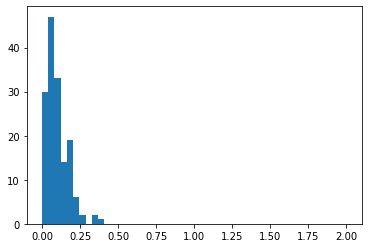

In [27]:
plt.hist(
    events.Muon[events.FatJet[cut].muonIdx3SJ].delta_r(events.FatJet[cut]).flatten(),
    bins=np.linspace(0,2,50),
);

In [28]:
jet = events.FatJet[lscut]
mu = events.Muon[jet.muonIdx3SJ]
cut = (mu.pt > 20) & (jet.lsf3 > 0.1) & (abs(mu.matched_gen.distinctParent.pdgId) == 24)

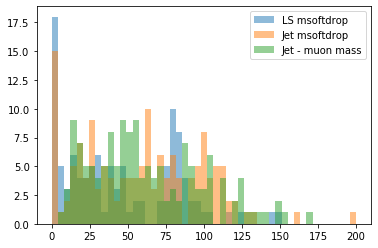

In [29]:
plt.hist(jet[cut].LSmsoftdrop.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='LS msoftdrop');
plt.hist(jet[cut].msoftdrop.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='Jet msoftdrop');
plt.hist((jet - mu)[cut].mass.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='Jet - muon mass');
plt.gca().legend()

In [30]:
events.materialized

{'Electron_cutBased',
 'Electron_pt',
 'FatJet_LSmsoftdrop',
 'FatJet_LSpt',
 'FatJet_eta',
 'FatJet_jetId',
 'FatJet_lsf3',
 'FatJet_mass',
 'FatJet_msoftdrop',
 'FatJet_muonIdx3SJ',
 'FatJet_n2b1',
 'FatJet_phi',
 'FatJet_pt',
 'GenPart_eta',
 'GenPart_genPartIdxMother',
 'GenPart_pdgId',
 'GenPart_phi',
 'GenPart_pt',
 'GenPart_statusFlags',
 'Jet_btagDeepB',
 'Jet_phi',
 'Jet_pt',
 'MET_phi',
 'MET_pt',
 'Muon_eta',
 'Muon_genPartIdx',
 'Muon_looseId',
 'Muon_mass',
 'Muon_phi',
 'Muon_pt',
 'Tau_idDecayMode',
 'Tau_pt',
 'nElectron',
 'nFatJet',
 'nGenPart',
 'nJet',
 'nMuon',
 'nTau'}

In [31]:
events.size

509